In [1]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages

In [10]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict,Counter
from imblearn.over_sampling import SMOTE
from PIL import Image

<h2>Data Loading and Preparation</h2>

In [4]:
def getSpeciesCode(x):
    part = x.split('_')
    if part[0] == 'ASETRI':
        return 0
    elif part[0] == 'EPTBOT':
        return 1
    elif part[0] == 'MYOEMA':
        return 2
    elif part[0] == 'PIPKUH':
        return 3
    elif part[0] == 'RHIMUS':
        return 4
    elif part[0] == 'RHYNAS':
        return 5
    elif part[0] == 'ROUAEG':
        return 6
    elif part[0] == 'TAPPER':
        return 7
    else:
        return 'Unknown'
    
def getSpecies(x):
    if x == 0:
        return 'A.tridens'
    elif x == 1:
        return 'E.bottae'
    elif x == 2:
        return 'M.emarginatus'
    elif x == 3:
        return 'P.kuhli'
    elif x == 4:
        return 'R.muscatellum'
    elif x == 5:
        return 'R.nasutus'
    elif x == 6:
        return 'R.aegyptius'
    elif x == 7:
        return 'T.perforatus'
    else:
        return 'Unknown'

# Ytrain in Onehot encoded form 
def makeOverSamplesSMOTE(X_train,Y_train):
    
    Y_train_labelled=[]
    X_dims=X_train.shape

    for i in range(len(Y_train)):
        Y_train_labelled.append(np.argmax(Y_train[i]))

    print('Original trainingset shape %s' %  [(getSpecies(k),v) for k,v in Counter(Y_train_labelled).items()])       
    X_train= X_train.reshape(-1,X_dims[1]*X_dims[2]*X_dims[3])

    sm = SMOTE(sampling_strategy='all',k_neighbors=5)
    X_train, Y_train_labelled = sm.fit_resample(X_train, Y_train_labelled)


    print('Resampled training set shape %s' % [(getSpecies(k),v) for k,v in Counter(Y_train_labelled).items()])


    #reshape X_all
    X_train= X_train.reshape(-1,X_dims[1],X_dims[2],X_dims[3])

    # update Y_train
    Y_train= np_utils.to_categorical(Y_train_labelled, num_classes=8)

    print("After OverSampling\nX_train: shape= ",X_train.shape)
    print("Y_train: shape= ",Y_train.shape)

    
    
    return(X_train,Y_train)

In [5]:
image_folder_path = '../data/MFCCinit'
file_paths = [f for f in os.listdir(image_folder_path)]
species = []
for file_name in file_paths:
    sp = file_name.split('_')
    species.append(sp[0])

df = pd.DataFrame(species, columns=['Species'])
df['Species'].value_counts()

RHIMUS    1799
TAPPER     429
PIPKUH     303
RHYNAS     271
EPTBOT     131
ROUAEG     121
MYOEMA     114
ASETRI      25
Name: Species, dtype: int64

In [6]:
X_all = []
Y_all = []

image_folder_path = '../data/MFCCinit'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = spectrogram.resize((341, 224))
    spectrogram = np.array(spectrogram)
    X_all.append(spectrogram)
    Y_all.append(getSpeciesCode(file_name))


In [7]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=8) 


(3193, 224, 341, 3)
(3193,)


In [12]:
# train /test= 80/20% split
# Data is stratified
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state = 245, stratify=Y_all)


X_train, Y_train= makeOverSamplesSMOTE(X_train, Y_train)

Original trainingset shape [('RHYNAS', 217), ('EPTBOT', 105), ('RHIMUS', 1439), ('TAPPER', 343), ('ASETRI', 20), ('PIPKUH', 242), ('MYOEMA', 91), ('ROUAEG', 97)]
Resampled training set shape [('RHYNAS', 1439), ('EPTBOT', 1439), ('RHIMUS', 1439), ('TAPPER', 1439), ('ASETRI', 1439), ('PIPKUH', 1439), ('MYOEMA', 1439), ('ROUAEG', 1439)]
After OverSampling
X_train: shape=  (11512, 224, 341, 3)
Y_train: shape=  (11512, 8)


<h2>Model Building</h2>

In [13]:

   def build_current_model():
    inp = Input(shape=(224,341,3))
    
    c1 = Convolution2D(filters=128,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    bt = BatchNormalization()(c1)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.2)(mpool)

    
    c2 = Convolution2D(filters=256,kernel_size=(5,5),strides=(2,2),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.3)(mpool)
    
    c2 = Convolution2D(filters=512,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.3)(mpool)
    
    c3 = Convolution2D(filters=512,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c3)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.4)(mpool)
    
    f = Flatten()(mpool)
    
    x_dense = Dense(2048)(f)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.4)(bt)

    
    x_dense = Dense(1024)(bt)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.3)(bt)
    
    x_dense = Dense(512)(bt)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.2)(bt)

    x_out = Dense(8, name='output', activation='softmax')(bt)
    
    model = Model(inputs=inp, outputs=x_out)
    model.compile(optimizer=Adam(lr=0.003), 
                  loss='categorical_crossentropy', 
                  metrics = ['accuracy'])
    return model




In [15]:
model = build_current_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 341, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 171, 128)     18944     
_________________________________________________________________
batch_normalization_7 (Batch (None, 112, 171, 128)     512       
_________________________________________________________________
activation_7 (Activation)    (None, 112, 171, 128)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 86, 128)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 56, 86, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 43, 256)       8194

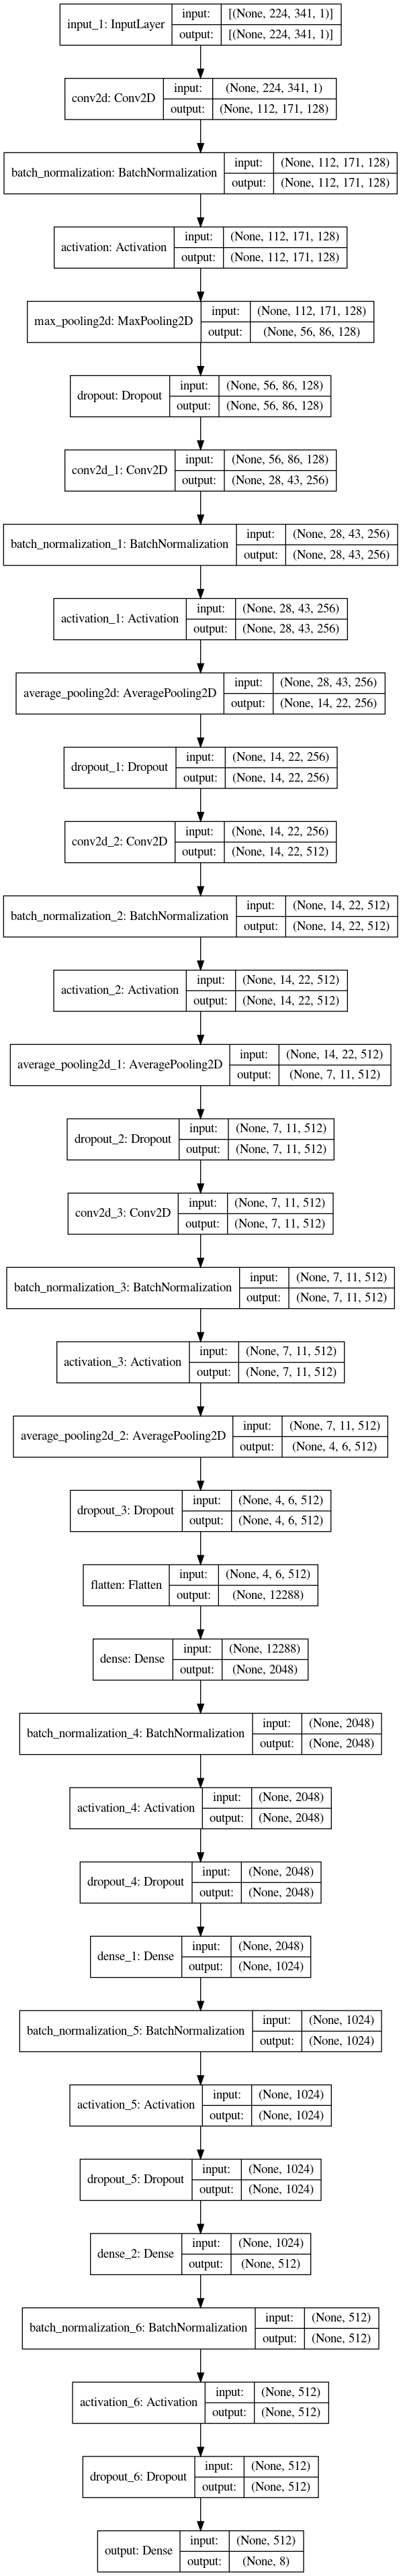

In [24]:
tf.keras.utils.plot_model(model, "Model2V8.png", show_shapes=True)

In [16]:

my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=25,verbose=1, mode='min',restore_best_weights=True)]

history = model.fit(X_train, Y_train, 
              epochs = 100, 
              validation_split=0.1, 
              verbose=1, 
              batch_size = 8,
#             class_weight = class_weight
                 callbacks=my_callbacks   )

history_info = history.history



Train on 10360 samples, validate on 1152 samples
Epoch 1/100
10360/10360 [==============================] - 48s 5ms/sample - loss: 1.1303 - acc: 0.6219 - val_loss: 4.0711 - val_acc: 0.1276
Epoch 2/100
10360/10360 [==============================] - 47s 5ms/sample - loss: 0.6060 - acc: 0.7862 - val_loss: 2.1862 - val_acc: 0.2795
Epoch 3/100
10360/10360 [==============================] - 47s 5ms/sample - loss: 0.4493 - acc: 0.8482 - val_loss: 3.2620 - val_acc: 0.1936
Epoch 4/100
10360/10360 [==============================] - 48s 5ms/sample - loss: 0.3472 - acc: 0.8837 - val_loss: 1.3615 - val_acc: 0.6007
Epoch 5/100
10360/10360 [==============================] - 48s 5ms/sample - loss: 0.3050 - acc: 0.9009 - val_loss: 0.6056 - val_acc: 0.7977
Epoch 6/100
10360/10360 [==============================] - 48s 5ms/sample - loss: 0.2411 - acc: 0.9217 - val_loss: 0.4586 - val_acc: 0.8481
Epoch 7/100
10360/10360 [==============================] - 49s 5ms/sample - loss: 0.2138 - acc: 0.9294 - val_lo

Epoch 59/100
10360/10360 [==============================] - 49s 5ms/sample - loss: 0.0351 - acc: 0.9914 - val_loss: 0.0403 - val_acc: 0.9826
Epoch 60/100
10360/10360 [==============================] - 49s 5ms/sample - loss: 0.0262 - acc: 0.9924 - val_loss: 0.0069 - val_acc: 0.9974
Epoch 61/100
10360/10360 [==============================] - 49s 5ms/sample - loss: 0.0254 - acc: 0.9931 - val_loss: 0.0218 - val_acc: 0.9887
Epoch 62/100
10360/10360 [==============================] - 49s 5ms/sample - loss: 0.0230 - acc: 0.9935 - val_loss: 0.2899 - val_acc: 0.9566
Epoch 63/100
10360/10360 [==============================] - 49s 5ms/sample - loss: 0.0316 - acc: 0.9919 - val_loss: 0.0033 - val_acc: 0.9991
Epoch 64/100
10360/10360 [==============================] - 49s 5ms/sample - loss: 0.0299 - acc: 0.9917 - val_loss: 9.0945e-04 - val_acc: 1.0000
Epoch 65/100
10360/10360 [==============================] - 49s 5ms/sample - loss: 0.0205 - acc: 0.9946 - val_loss: 0.0789 - val_acc: 0.9748
Epoch 66/

<h2>Evaluation (Basic)</h2>

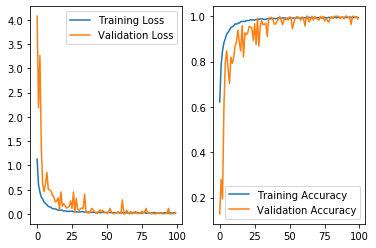

In [17]:
## Loss and accuracy history
_, axs = plt.subplots(ncols=2)
df_history_info = pd.DataFrame(history_info) 


sns.lineplot(data=df_history_info['loss'],ax=axs[0], label='Training Loss', legend='brief')
sns.lineplot(data=df_history_info['val_loss'],ax=axs[0], label='Validation Loss', legend='brief')

sns.lineplot(data=df_history_info['acc'],ax=axs[1], label='Training Accuracy', legend='brief')
sns.lineplot(data=df_history_info['val_acc'],ax=axs[1], label='Validation Accuracy', legend='brief')

In [18]:
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted

[[  4   0   0   0   0   0   1   0]
 [  0  22   1   0   2   0   1   0]
 [  0   0  15   2   3   0   3   0]
 [  0   0   1  58   1   1   0   0]
 [  0   0   2   1 351   0   4   2]
 [  0   0   0   2   1  51   0   0]
 [  0   0   0   1   2   0  21   0]
 [  0   0   1   1   7   0   0  77]]


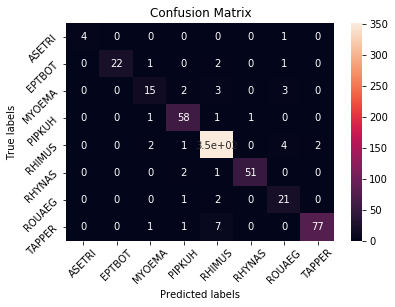

In [19]:
Y_pred = model.predict(X_test)
actual, predicted = generate_actual_predicted(Y_pred, X_test, Y_test)

##Confusion Matrix
from sklearn.metrics import confusion_matrix
actual_labeled = list()
predict_labeled = list()
for x,y in zip(actual,predicted):
    actual_labeled.append(getSpecies(x))
    predict_labeled.append(getSpecies(y))

labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

In [20]:
## Test accuracy
from sklearn.metrics import accuracy_score
print('accuracy', accuracy_score(actual, predicted))


accuracy 0.9374021909233177


In [21]:
## Precision, Recall, F1, Support
from sklearn.metrics import classification_report
print(classification_report(actual_labeled, predict_labeled,labels=labels))

              precision    recall  f1-score   support

      ASETRI       1.00      0.80      0.89         5
      EPTBOT       1.00      0.85      0.92        26
      MYOEMA       0.75      0.65      0.70        23
      PIPKUH       0.89      0.95      0.92        61
      RHIMUS       0.96      0.97      0.97       360
      RHYNAS       0.98      0.94      0.96        54
      ROUAEG       0.70      0.88      0.78        24
      TAPPER       0.97      0.90      0.93        86

    accuracy                           0.94       639
   macro avg       0.91      0.87      0.88       639
weighted avg       0.94      0.94      0.94       639



In [25]:
##ROC AUC Scores
from sklearn.metrics import roc_auc_score
print('One-vs-One ROC AUC scores:')
print(roc_auc_score(actual, Y_pred, average='macro', multi_class='ovo'), '(macro)')
print(roc_auc_score(actual, Y_pred, average='weighted', multi_class='ovo'), '(weighted by prevalence)')


print()
print('One-vs-Rest ROC AUC scores:')
print(roc_auc_score(actual, Y_pred, average='macro', multi_class='ovr'), '(macro)')
print(roc_auc_score(actual, Y_pred, average='weighted', multi_class='ovr'), '(weighted by prevalence)')

One-vs-One ROC AUC scores:
0.9892541063435292 (macro)
0.9927520445013543 (weighted by prevalence)

One-vs-Rest ROC AUC scores:
0.9931538863796511 (macro)
0.994455206971261 (weighted by prevalence)


/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


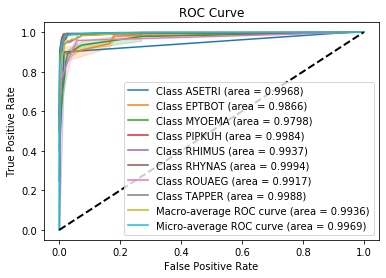

In [26]:
## ROC Curves
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from scipy import interp

### The following curves are generated s.t each point is a model from differing thresholds

### ROC Curves + AUC per class

_, axs = plt.subplots(ncols=1)
axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve')

fpr = [0] * 8
tpr = [0] * 8
for i in range(8):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:,i], Y_pred[:,i])
    auc_val = auc(fpr[i], tpr[i])
    auc_val = np.around(auc_val,4)
    sns.lineplot(x=fpr[i],y=tpr[i],ax=axs, label='Class '+ getSpecies(i) +' (area = ' + str(auc_val) + ')', legend='brief')

#### Micro/Macro ROC Curves + AUC over all classes

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(8)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(8):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= 8

fpr_macro = all_fpr
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)
fpr_micro, tpr_micro,_ = roc_curve(Y_test.ravel(), Y_pred.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


roc_auc_macro = np.around(roc_auc_macro,4)
roc_auc_micro = np.around(roc_auc_micro,4)
sns.lineplot(x=fpr_macro,y=tpr_macro,ax=axs, label='Macro-average ROC curve (area = ' + str(roc_auc_macro) + ')', legend='brief')
sns.lineplot(x=fpr_micro,y=tpr_micro,ax=axs, label='Micro-average ROC curve (area = ' + str(roc_auc_micro) + ')', legend='brief')

## Diagonal line for comparison
plt.plot([0, 1], [0, 1], 'k--', lw=2)

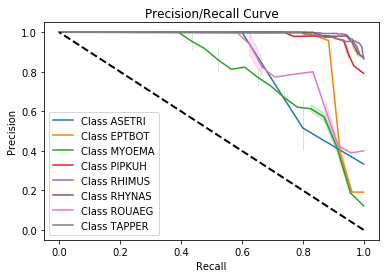

In [27]:
## Precision/Recall Curves per class
### The following curves are generated s.t each point is a model from differing thresholds
from sklearn.metrics import precision_recall_curve

_, axs = plt.subplots(ncols=1)
axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve')

prec = [0] * 8
rec = [0] * 8
for i in range(8):
    prec[i], rec[i], _ = precision_recall_curve(Y_test[:,i], Y_pred[:,i])
    sns.lineplot(x=rec[i],y=prec[i],ax=axs, label='Class '+ getSpecies(i), legend='brief')

# Diagonal line for comparison
plt.plot([1, 0], [0, 1], 'k--', lw=2)

<h2>K-Fold Training and Evaluation</h2>

In [ ]:
#Precision Mean and Standard Deviation
#Recall Mean and Standard Deviation
#F1 Measure Mean and Standard Deviation
#True Positive Rate. Mean and Standard Deviation
#False Negative Rate Mean and Standard Deviation
#Best/Worst ROC
#Best/Worst Precision/Recall
#Accuracy Mean and Standard Deviation

In [20]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()


all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()


n_split=5
n_classes=8

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
        
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=25,verbose=1, mode='min',restore_best_weights=True)]
       
for train_index,test_index in StratifiedKFold(n_split).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
    #oversample
    X_train, Y_train= makeOverSamplesSMOTE(X_train, Y_train)
       
    # create and fit the model
    cv_model=build_current_model() # lr,dense,cnn
    history = cv_model.fit(x_train, y_train,
              batch_size=8,
              epochs=100,
              validation_split=0.1,
              verbose=1,
            callbacks=my_callbacks)
    
    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')
    
    
    actual_labeled = list()
    predict_labeled = list()
    for x,y in zip(actual,predicted):
        actual_labeled.append(getSpecies(x))
        predict_labeled.append(getSpecies(y))
        
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
    curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_cm.append(curr_cm)
    
    
    

Train on 2298 samples, validate on 256 samples
Epoch 1/100
2298/2298 [==============================] - 11s 5ms/sample - loss: 1.4195 - acc: 0.5727 - val_loss: 2.4802 - val_acc: 0.5078
Epoch 2/100
2298/2298 [==============================] - 11s 5ms/sample - loss: 1.1285 - acc: 0.6397 - val_loss: 1.0356 - val_acc: 0.6602
Epoch 3/100
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.8883 - acc: 0.7093 - val_loss: 1.0356 - val_acc: 0.6953
Epoch 4/100
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.8215 - acc: 0.7211 - val_loss: 3.2107 - val_acc: 0.5703
Epoch 5/100
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.9935 - acc: 0.6675 - val_loss: 1.0355 - val_acc: 0.6562
Epoch 6/100
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.9402 - acc: 0.6767 - val_loss: 0.8018 - val_acc: 0.7578
Epoch 7/100
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.7725 - acc: 0.7454 - val_loss: 0.5187 - val

Epoch 18/100
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.4309 - acc: 0.8542 - val_loss: 0.3448 - val_acc: 0.8594
Epoch 19/100
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.4126 - acc: 0.8494 - val_loss: 0.3443 - val_acc: 0.8633
Epoch 20/100
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.3858 - acc: 0.8625 - val_loss: 0.3699 - val_acc: 0.8477
Epoch 21/100
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.6499 - acc: 0.7942 - val_loss: 0.3103 - val_acc: 0.8867
Epoch 22/100
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.5022 - acc: 0.8281 - val_loss: 0.3505 - val_acc: 0.8750
Epoch 23/100
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.4078 - acc: 0.8599 - val_loss: 0.2838 - val_acc: 0.8984
Epoch 24/100
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.3883 - acc: 0.8660 - val_loss: 0.3107 - val_acc: 0.8750
Epoch 25/100
2298/2298 [===

Epoch 77/100
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.1089 - acc: 0.9682 - val_loss: 0.1505 - val_acc: 0.9453
Epoch 78/100
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.0957 - acc: 0.9695 - val_loss: 0.1251 - val_acc: 0.9570
Epoch 79/100
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.0942 - acc: 0.9704 - val_loss: 0.1272 - val_acc: 0.9648
Epoch 80/100
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.0834 - acc: 0.9739 - val_loss: 0.1110 - val_acc: 0.9648
Epoch 81/100
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.0920 - acc: 0.9713 - val_loss: 0.1596 - val_acc: 0.9414
Epoch 82/100
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.0788 - acc: 0.9721 - val_loss: 0.2213 - val_acc: 0.9531
Epoch 83/100
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.0934 - acc: 0.9700 - val_loss: 0.1707 - val_acc: 0.9531
Epoch 84/100
2298/2298 [===

2298/2298 [==============================] - 11s 5ms/sample - loss: 0.0913 - acc: 0.9713 - val_loss: 0.1776 - val_acc: 0.9492
Epoch 95/100
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.1175 - acc: 0.9621 - val_loss: 0.1499 - val_acc: 0.9570
Epoch 96/100
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.1030 - acc: 0.9652 - val_loss: 0.1918 - val_acc: 0.9453
Epoch 97/100
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.1483 - acc: 0.9517 - val_loss: 0.2039 - val_acc: 0.9375
Epoch 98/100
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.2758 - acc: 0.9195 - val_loss: 0.2187 - val_acc: 0.9336
Epoch 99/100
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.1636 - acc: 0.9456 - val_loss: 0.2066 - val_acc: 0.9297
Epoch 100/100
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.1548 - acc: 0.9465 - val_loss: 0.2124 - val_acc: 0.9336
Train on 2299 samples, validate on 256 

Epoch 53/100
2299/2299 [==============================] - 11s 5ms/sample - loss: 0.1582 - acc: 0.9469 - val_loss: 0.1750 - val_acc: 0.9414
Epoch 54/100
2299/2299 [==============================] - 11s 5ms/sample - loss: 0.1467 - acc: 0.9469 - val_loss: 0.1733 - val_acc: 0.9375
Epoch 55/100
2299/2299 [==============================] - 11s 5ms/sample - loss: 0.1446 - acc: 0.9487 - val_loss: 0.2207 - val_acc: 0.9141
Epoch 56/100
2299/2299 [==============================] - 11s 5ms/sample - loss: 0.1700 - acc: 0.9421 - val_loss: 0.2037 - val_acc: 0.9180
Epoch 57/100
2299/2299 [==============================] - 11s 5ms/sample - loss: 0.1529 - acc: 0.9487 - val_loss: 0.1612 - val_acc: 0.9453
Epoch 58/100
2299/2299 [==============================] - 11s 5ms/sample - loss: 0.1090 - acc: 0.9609 - val_loss: 0.1366 - val_acc: 0.9531
Epoch 59/100
2299/2299 [==============================] - 11s 5ms/sample - loss: 0.1550 - acc: 0.9500 - val_loss: 0.2588 - val_acc: 0.9336
Epoch 60/100
2299/2299 [===

In [21]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [0.86       0.93179894 0.83325197 0.92059499 0.97715754 0.91051522
 0.7268599  0.93738506]
precision sdev by class [0.19595918 0.06572536 0.09763728 0.03200754 0.00672628 0.03331355
 0.15285087 0.03427803]
macro precision mean 0.8871954535276423
macro precision sdev 0.0527120779625821
recall mean [0.92       0.84700855 0.70395257 0.93699454 0.97110028 0.92626263
 0.85933333 0.93461012]
recall sdev [0.09797959 0.06015783 0.16530247 0.0415601  0.01198428 0.0259587
 0.04292888 0.03043153]
macro recall mean 0.8874077516205174
macro recall sdev 0.038108001072106254
f1 mean [0.87111111 0.88443619 0.75900164 0.92785448 0.97405052 0.91798434
 0.78167676 0.93577523]
f1 sdev [0.12680305 0.03951185 0.13393997 0.0242233  0.00529498 0.0241838
 0.10375292 0.02903775]
macro f1 mean 0.8814862840733213
macro f1 sdev 0.04752414963984272
accuracy mean 0.939868819324866
accuracy sdev 0.01814959654199797


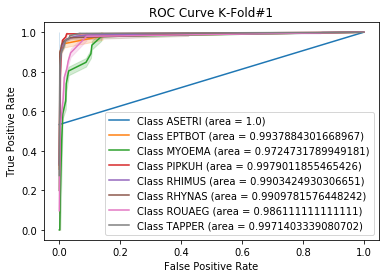

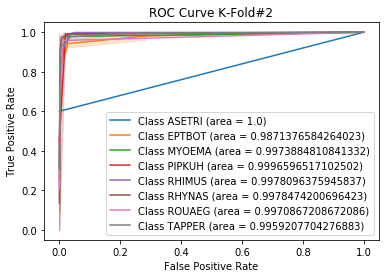

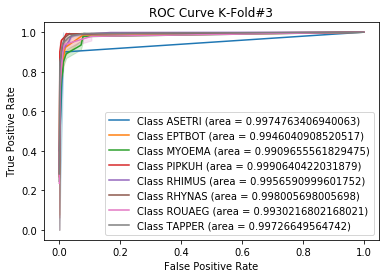

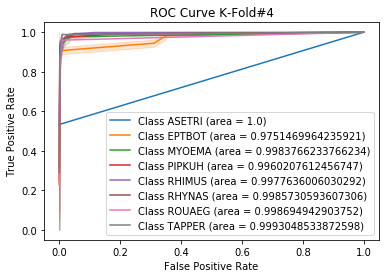

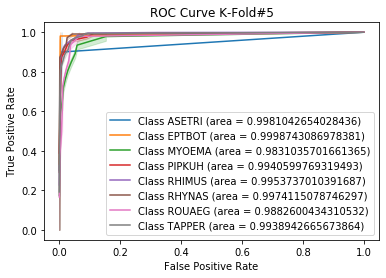

In [22]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        auc_val = np.around(auc_val,4)
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j) +' (area = ' + str(auc_val) + ')', legend='brief')
        

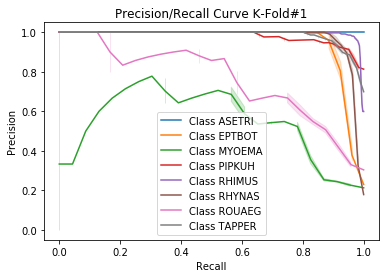

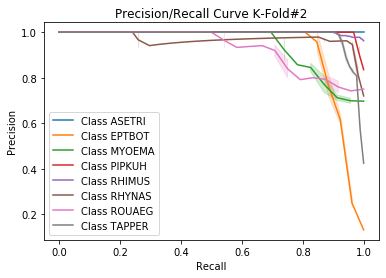

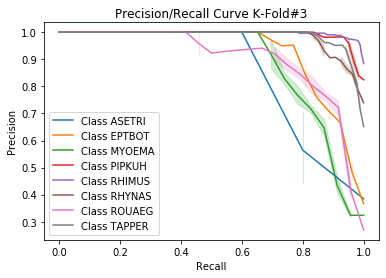

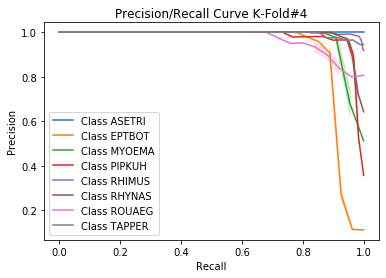

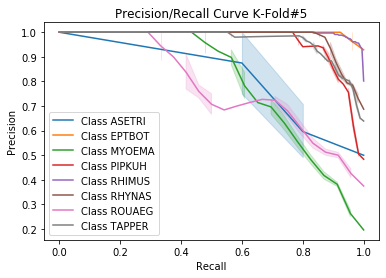

In [23]:
#Plot all K-Fold Precision/Recall curves
for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

Confusion Matrix K-Fold #1

[[  5   0   0   0   0   0   0   0]
 [  0  22   0   0   0   2   2   0]
 [  1   0  10   4   1   0   6   1]
 [  0   0   0  58   0   3   0   0]
 [  0   0   3   0 343   1   5   8]
 [  0   0   1   1   0  51   1   0]
 [  3   0   1   0   0   0  20   0]
 [  1   0   0   0   3   0   1  81]]


Confusion Matrix K-Fold #2

[[  5   0   0   0   0   0   0   0]
 [  0  23   0   0   2   1   0   0]
 [  0   0  17   2   2   0   2   0]
 [  0   0   0  60   0   1   0   0]
 [  0   1   0   1 354   0   2   2]
 [  0   3   0   1   0  50   0   0]
 [  0   0   1   0   1   0  22   0]
 [  0   0   0   0   4   0   2  80]]


Confusion Matrix K-Fold #3

[[  4   0   0   0   0   0   1   0]
 [  0  19   0   0   4   2   1   0]
 [  0   0  16   2   1   1   3   0]
 [  0   0   1  59   0   1   0   0]
 [  0   0   0   2 352   1   1   4]
 [  0   0   1   5   0  48   0   0]
 [  0   0   0   0   3   0  21   0]
 [  0   1   1   0   3   0   0  81]]


Confusion Matrix K-Fold #4

[[  5   0   0   0   0   0   0   0]
 [  

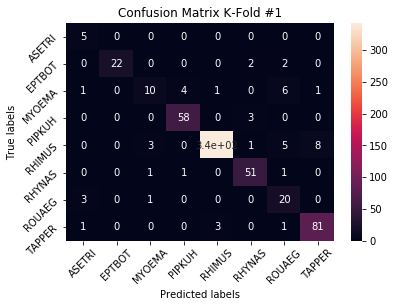

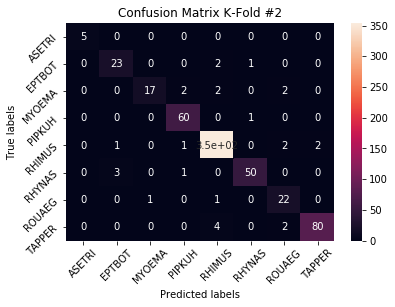

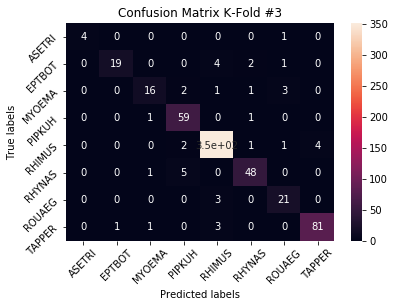

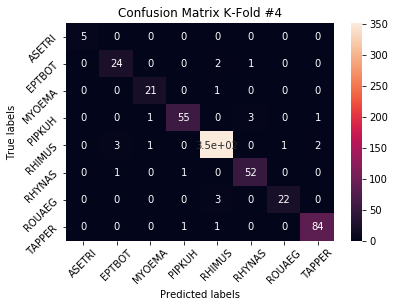

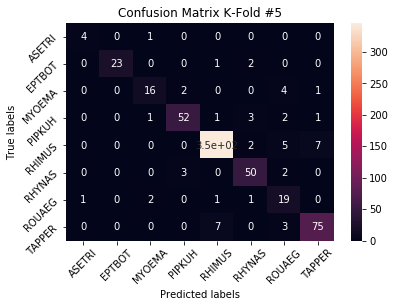

In [24]:
## Plot all K-Fold confusion matrices
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

# Create 1X 5 sub plots
# gs = gridspec.GridSpec(1,n_split)
figs=[]
for i in range(n_split):
    figs.append(plt.figure())
    
for i in range(n_split):
    print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
    print(all_cm[i])
    print("\n")
    
    ax=figs[i].add_subplot()
    sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

sum of all confuion matrices
 [[  23    0    1    0    0    0    1    0]
 [   0  111    0    0    9    8    3    0]
 [   1    0   80   10    5    1   15    2]
 [   0    0    3  284    1   11    2    2]
 [   0    4    4    3 1747    4   14   23]
 [   0    4    2   11    0  251    3    0]
 [   4    0    4    0    8    1  104    0]
 [   1    1    1    1   18    0    6  401]]

average of all confuion matrices
 [[  4   0   0   0   0   0   0   0]
 [  0  22   0   0   1   1   0   0]
 [  0   0  16   2   1   0   3   0]
 [  0   0   0  56   0   2   0   0]
 [  0   0   0   0 349   0   2   4]
 [  0   0   0   2   0  50   0   0]
 [  0   0   0   0   1   0  20   0]
 [  0   0   0   0   3   0   1  80]]


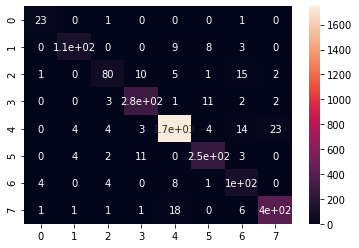

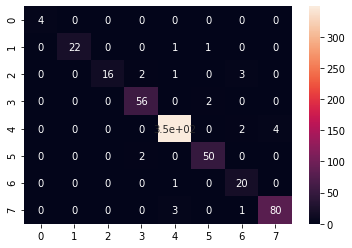

In [25]:
## plot macro cm

sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
for i in range(n_split):
    sum_all_cm+=all_cm[i]
    
    
#plot 
figs=[]
for i in range(2):
    figs.append(plt.figure())
       
print("sum of all confuion matrices\n",sum_all_cm)
ax=figs[0].add_subplot()
sns.heatmap(sum_all_cm, annot=True, ax = ax);

avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
print("\naverage of all confuion matrices\n",avg_all_cm)
ax=figs[1].add_subplot()
sns.heatmap(avg_all_cm, annot=True, ax = ax);

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['ASETRI','EPTBOT','MYOEMA','PIPKUH','RHIMUS','RHYNAS', 'ROUAEG', 'TAPPER']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

<h2>Storing/Loading history and model to file</h2>

In [23]:
#Store History
hist_df = pd.DataFrame(history.history) 
hist_json_file = 'Model2-P-bats.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [25]:
#Load History 
history_info = pd.read_json('Model2-P-bats.json')

In [26]:
##Save Model
model.save('Model2-P-bats_trained.model') #Save the model

In [27]:
## Load Model
model = tf.keras.models.load_model('Model2V2-bats_trained.model') #Re load model

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
